# Knowledge Informed Machine Learning using a Weibull-based Loss Function
> Exploring the concept of knowledge-informed machine learning with the use of a Weibull-based loss function. Used to predict remaining useful life (RUL) on the [IMS](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#bearing) and [PRONOSTIA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#femto) (also called FEMTO) bearing data sets.

This notebook reproduces the results from the paper "Knowledge Informed Machine Learning using a Weibull-based Loss Function". The notebook also provides additional data exploration and explanation of the code used in the experiments.

**Note:** You can replicate the results without having to download the data in Section 2. The raw data is only needed for the data exploration.

If you have any questions, feel free to reach out or leave a question in the [discussions](https://github.com/tvhahn/weibull-knowledge-informed-ml/discussions).

## Table of Contents
* [1. Setup Notebook](#1.-Setup-Notebook) - clone the repo and import require packages
* [2. Explore Data](#2.-Explore-Data) - download the raw data and see how it looks
* [3. Create Train/Val/Test Sets](#3.-Create-Train/Val/Test-Sets) - create the data splits (if you want) and visualize them
* [4. Train Models with a Random Search](#4.-Train-Models-with-a-Random-Search) - train the models
* [5. Summarize Results](#5.-Summarize-Results) - summarize the results of the random search to find the most effective loss functions

# 1. Setup Notebook
**For Google Colab:**
To run the notebook on google colab you must clone the repo an download the data

In [1]:
!git clone https://github.com/tvhahn/weibull-knowledge-informed-ml.git

# move into project folder
%cd weibull-knowledge-informed-ml

# make editable
!pip install gdown
!pip install -e .

Cloning into 'weibull-knowledge-informed-ml'...
remote: Enumerating objects: 1051, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1051 (delta 67), reused 66 (delta 46), pack-reused 955 (from 1)
Receiving objects: 100% (1051/1051), 49.76 MiB | 12.01 MiB/s, done.
Resolving deltas: 100% (666/666), done.
/content/weibull-knowledge-informed-ml
Obtaining file:///content/weibull-knowledge-informed-ml
  Preparing metadata (setup.py) ... done
  Running setup.py develop for src


**Import Packages:**
Don't skip this step! Needed for Google Colab and if run locally.

In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, fftpack
import time
import datetime
import h5py
from shutil import copyfile

from src.features.build_features import (
    create_fft,
    build_spectrogram_df_ims,
    build_spectrogram_df_femto
)

from src.visualization.visualize_data import (
    create_time_frequency_plot,
    plot_freq_peaks,
    plot_spectogram_with_binned,
    ims_data_processed_fig,
    femto_data_processed_fig,
)

from src.visualization.visualize_results import (
    loss_function_percentage_fig,
    early_stop_distribution_fig,
    loss_function_correlation_fig,
    femto_results_rul_fig,
    ims_results_rul_fig,
)

from src.data.data_utils import (
    create_date_dict,
    load_train_test_ims,
    load_train_test_femto
)

from IPython.display import clear_output, display, Image # clear the output if needed
import warnings
warnings.filterwarnings("ignore") # supress all the matplotlib deprecation warnings
%load_ext autoreload
%autoreload 2

Assume on local compute


In [3]:
# set the root (parent folder) and the data folder locations
path_colab = Path.cwd().parent.parent / 'content'

if path_colab.exists():
    root_dir = Path.cwd() # get root folder of repository - use if on colab
else:
    root_dir = Path.cwd().parent # on local machine in ./notebooks folder

print(root_dir)

/content/weibull-knowledge-informed-ml


# 2. Explore Data
Let's explore the data!

Start by downloading the IMS and PRONOSTIA (FEMTO) bearing data sets from the NASA Prognostics Repository.

In [4]:
!bash /content/weibull-knowledge-informed-ml/src/data/download_data_local.sh /content/weibull-knowledge-informed-ml

2025-05-30 14:06:25,989 - __main__ - INFO - downloading...
2025-05-30 14:06:58,319 - __main__ - INFO - downloading done


Extract the downloaded data. (note: will take several minutes to extract)

In [5]:
!bash /content/weibull-knowledge-informed-ml/src/data/extract_data_local.sh /content/weibull-knowledge-informed-ml

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Test_set/Bearing2_3/acc_00443.csv  
  inflating: Test_set/Bearing2_3/acc_00444.csv  
  inflating: Test_set/Bearing2_3/acc_00445.csv  
  inflating: Test_set/Bearing2_3/acc_00446.csv  
  inflating: Test_set/Bearing2_3/acc_00447.csv  
  inflating: Test_set/Bearing2_3/acc_00448.csv  
  inflating: Test_set/Bearing2_3/acc_00449.csv  
  inflating: Test_set/Bearing2_3/acc_00450.csv  
  inflating: Test_set/Bearing2_3/acc_00451.csv  
  inflating: Test_set/Bearing2_3/acc_00452.csv  
  inflating: Test_set/Bearing2_3/acc_00453.csv  
  inflating: Test_set/Bearing2_3/acc_00454.csv  
  inflating: Test_set/Bearing2_3/acc_00455.csv  
  inflating: Test_set/Bearing2_3/acc_00456.csv  
  inflating: Test_set/Bearing2_3/acc_00457.csv  
  inflating: Test_set/Bearing2_3/acc_00458.csv  
  inflating: Test_set/Bearing2_3/acc_00459.csv  
  inflating: Test_set/Bearing2_3/acc_00460.csv  
  inflating: Test_set/Bearing2_3/acc_00461.csv  
  inflating: Test_set/Bearing2_3/acc_00462

Look at some of the IMS data.

In [6]:
folder_raw_data = root_dir / 'data/raw/IMS/' # raw data folder

# load text file for first measurement
# first test folder location
folder_1st = folder_raw_data / '1st_test'

# can use numpy...
d = np.loadtxt(folder_1st / '2003.10.22.12.06.24')

# let's use pandas
    # b1_ch1 - Bearing 1, channel 1
    # b1_ch2 - Bearing 1, channel 2
    # etc, etc ...

col_names = ['b1_ch1', 'b1_ch2', 'b2_ch3', 'b2_ch4', 'b3_ch5', 'b3_ch6', 'b4_ch7', 'b4_ch8']
df = pd.read_csv(folder_1st / '2003.10.22.12.06.24', sep='\t', names=col_names)
df.head()

b1_ch1  b1_ch2  b2_ch3  b2_ch4  b3_ch5  b3_ch6  b4_ch7  b4_ch8
0  -0.022  -0.039  -0.183  -0.054  -0.105  -0.134  -0.129  -0.142
1  -0.105  -0.017  -0.164  -0.183  -0.049   0.029  -0.115  -0.122
2  -0.183  -0.098  -0.195  -0.125  -0.005  -0.007  -0.171  -0.071
3  -0.178  -0.161  -0.159  -0.178  -0.100  -0.115  -0.112  -0.078
4  -0.208  -0.129  -0.261  -0.098  -0.151  -0.205  -0.063  -0.066

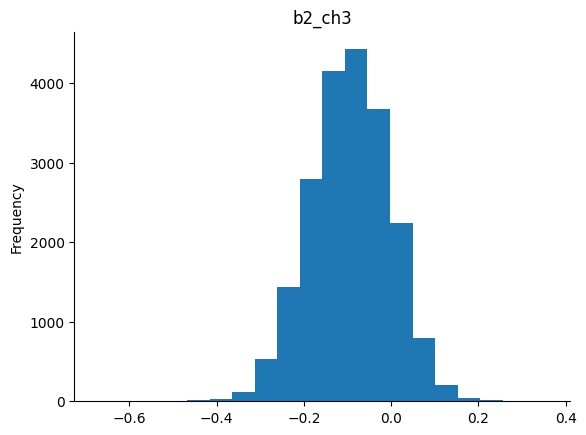

In [8]:
# @title b2_ch3

from matplotlib import pyplot as plt
df['b2_ch3'].plot(kind='hist', bins=20, title='b2_ch3')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# what is the shape of the dataframe?
df.shape

(20480, 8)

Gousseau et al. postulate in their paper ['Analysis of the Rolling Element Bearing data set of the Center for Intelligent Maintenance Systems of theUniversity of Cincinnati'](https://hal.archives-ouvertes.fr/hal-01715193) that the actual collection frequency is 20.48 kHz.

We will use this collection frequency.

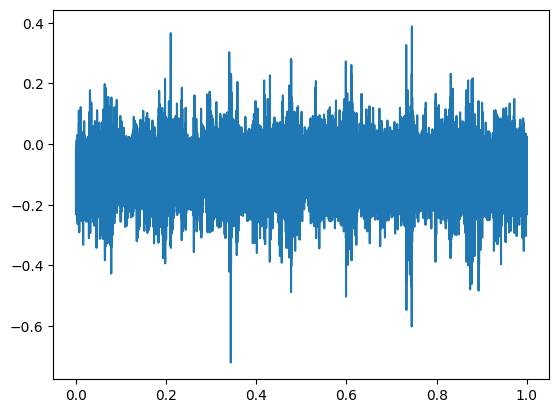

In [7]:
# plot first bearing channel
fig, ax = plt.subplots()

ax.plot(
    np.arange(0,df.shape[0], dtype='float64') / (20.48 * 10**3), # make x-axis in seconds
    df['b1_ch1'] # acceleration data
)

We will want to "detrend" and window the signal -- this is a basic signal processing step.

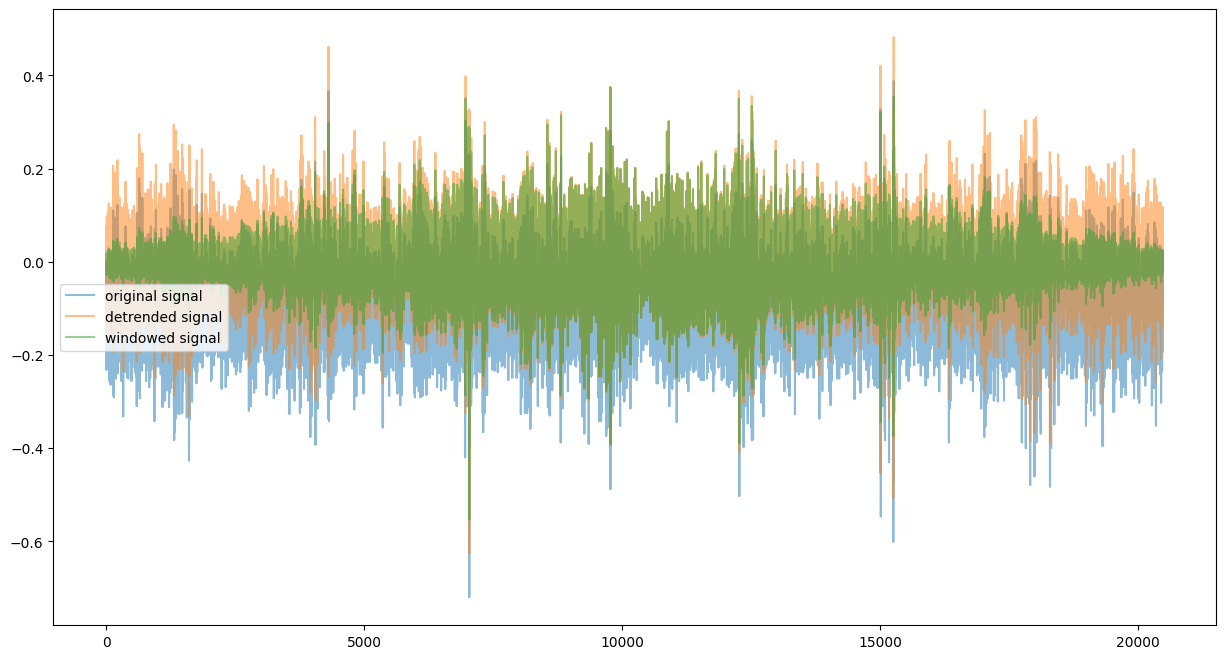

In [9]:
# practice detrending
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['b1_ch1'], alpha=0.5, label='original signal')
y_detrend = signal.detrend(df['b1_ch1'], type="linear")
plt.plot(y_detrend, alpha=0.5, label='detrended signal')

# apply either a hamming or kaiser windowing function
# y_detrend *= np.hamming(len(y_detrend))
y_detrend *= np.kaiser(len(y_detrend), 3)
plt.plot(y_detrend, alpha=0.5, label='windowed signal')
plt.legend(loc='center left')

Use a function to create the FFT (`create_fft`), and another function to plot the time and frequency domains (`create_time_frequency_plot`).

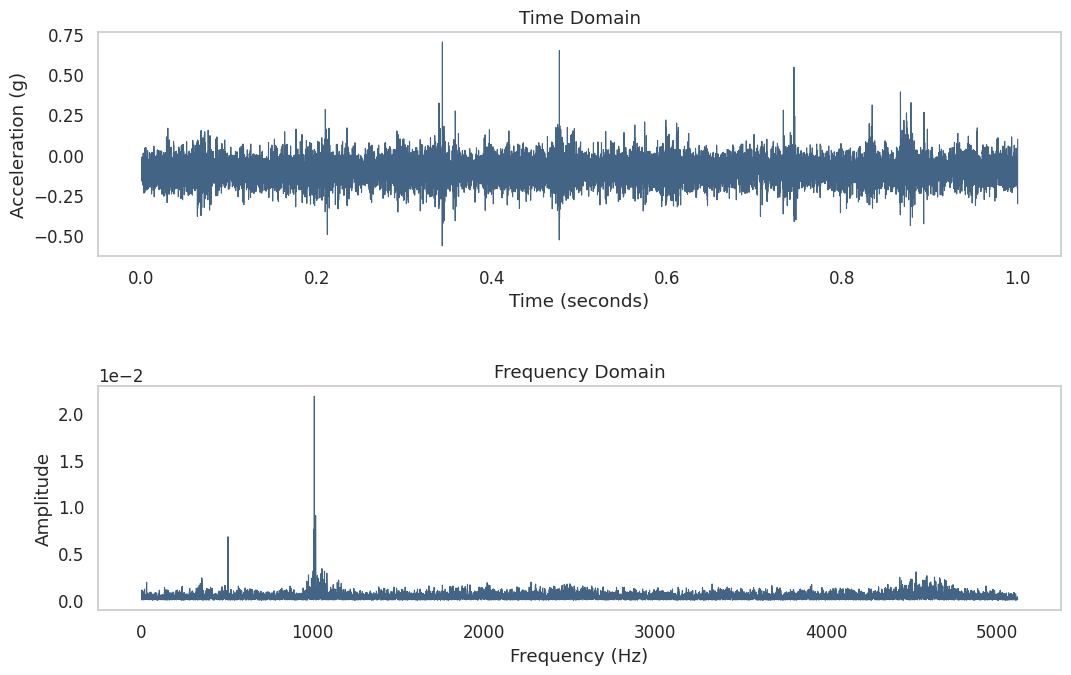

In [10]:
# create fft
x, y, xf, yf = create_fft(df, y_name='b1_ch2', sample_freq=20480.0, window='kaiser', beta=3)

# plot
create_time_frequency_plot(x, y, xf, yf, save_plot=False)

It is interesting to look at the peaks in the frequency domain plot, since different peaks can correspond to different parts of the bearing.example.ipynb

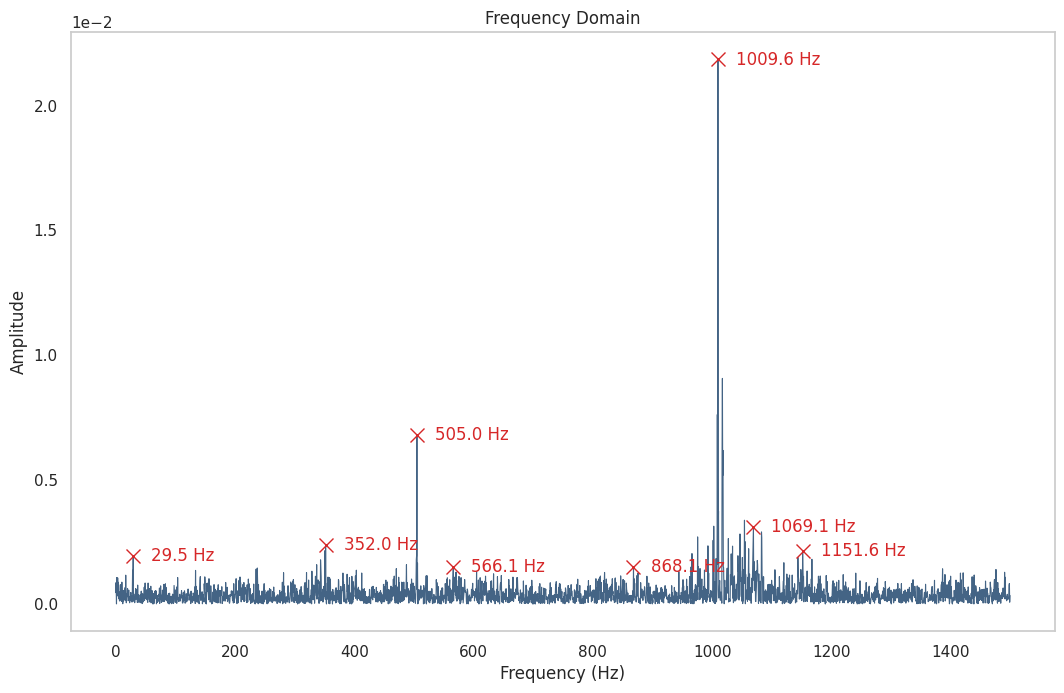

In [11]:
# only plot to 1500 Hz
plot_freq_peaks(xf, yf, max_freq_to_plot=1500, peak_height=0.0015, peak_distance=50)

## 2.1 Build Spectrograms - IMS
We will create a spectrogram of each run. A spectrogram is merely a "stack" of FFTs over time.

We have created a function, `build_spectrogram_df_ims`, that creates the spectrogram.

In [12]:
folder_1st = folder_raw_data / "1st_test"

date_list = sorted(os.listdir(folder_1st))

col_names = [
    "b1_ch1",
    "b1_ch2",
    "b2_ch3",
    "b2_ch4",
    "b3_ch5",
    "b3_ch6",
    "b4_ch7",
    "b4_ch8",
]

df_spec, labels_dict = build_spectrogram_df_ims(
    folder_1st,
    date_list,
    channel_name="b3_ch5",
    start_time=date_list[0],
    col_names=col_names,
)

The output from the `build_spectrogram_df_ims` is a dataframe of the spectrogram, and a dictionary of the times when the signals were collected. Here's what the dataframe looks like:

In [13]:
df_spec.head()

2003-10-22 12:06:24  2003-10-22 12:09:13  2003-10-22 12:14:13  \
0.000000             0.000376             0.000613             0.000252   
0.500049             0.000945             0.001218             0.000698   
1.000098             0.000063             0.000332             0.000939   
1.500146             0.000576             0.000218             0.000920   
2.000195             0.001071             0.000454             0.000430   

          2003-10-22 12:19:13  2003-10-22 12:24:13  2003-10-22 12:29:13  \
0.000000             0.000441             0.000521             0.000036   
0.500049             0.000682             0.000989             0.000282   
1.000098             0.000389             0.000121             0.000352   
1.500146             0.000175             0.000368             0.000339   
2.000195             0.000346             0.001266             0.000625   

          2003-10-22 12:34:13  2003-10-22 12:39:13  2003-10-22 12:44:13  \
0.000000             0.000209             0.000456             0.000166   
0.500049             0.000364             0.000892             0.000415   
1.000098             0.000437             0.000919             0.001642   
1.500146             0.000217             0.000456             0.000262   
2.000195             0.000926             0.000582             0.000379   

          2003-10-22 12:49:13  ...  2003-11-25 15:17:32  2003-11-25 15:27:32  \
0.000000             0.000390  ...             0.000330             0.000165   
0.500049             0.000716  ...             0.000763             0.000441   
1.000098             0.000924  ...             0.001127             0.001378   
1.500146             0.000114  ...             0.001530             0.001394   
2.000195             0.000170  ...             0.000098             0.003607   

          2003-11-25 15:37:32  2003-11-25 15:47:32  2003-11-25 15:57:32  \
0.000000             0.000045             0.000075             0.000470   
0.500049             0.000975             0.000540             0.000395   
1.000098             0.001142             0.000337             0.001335   
1.500146             0.002433             0.002552             0.001853   
2.000195             0.000065             0.001958             0.001119   

          2003-11-25 16:07:32  2003-11-25 23:13:21  2003-11-25 23:19:56  \
0.000000             0.000686             0.001904             0.001696   
0.500049             0.001483             0.002665             0.003242   
1.000098             0.000386             0.001652             0.004217   
1.500146             0.001799             0.001231             0.001667   
2.000195             0.001281             0.003249             0.000946   

          2003-11-25 23:29:56  2003-11-25 23:39:56  
0.000000             0.000245             0.065340  
0.500049             0.000473             0.129645  
1.000098             0.000916             0.141756  
1.500146             0.000590             0.062438  
2.000195             0.001417             0.096466  

[5 rows x 2156 columns]

Here is a value from the `labels_dict`, generated from the above function. Each key in the dictionary represents a list that holds five time values/formats.

* Date with a nice format, like `2003-10-22 12:34:13`
* Date with underscores, like `2003_10_22_12_34_13` - this is also the key for this dictionary item.
* Unix timestamp, like `1066851253.0`
* Time increment since start of run (in seconds), like `1669.0`
* Time increment since start of run (in days), like `0.01931712962962963`

In [14]:
labels_dict['2003_10_22_12_34_13']

['2003-10-22 12:34:13',
 '2003_10_22_12_34_13',
 1066826053.0,
 1669.0,
 0.01931712962962963]

Let's plot the spectrogram.

The spectrogram is fairly "dim" unless you add a "vmax" value. This is partly because the 1000 Hz peak is dominating the FFT.

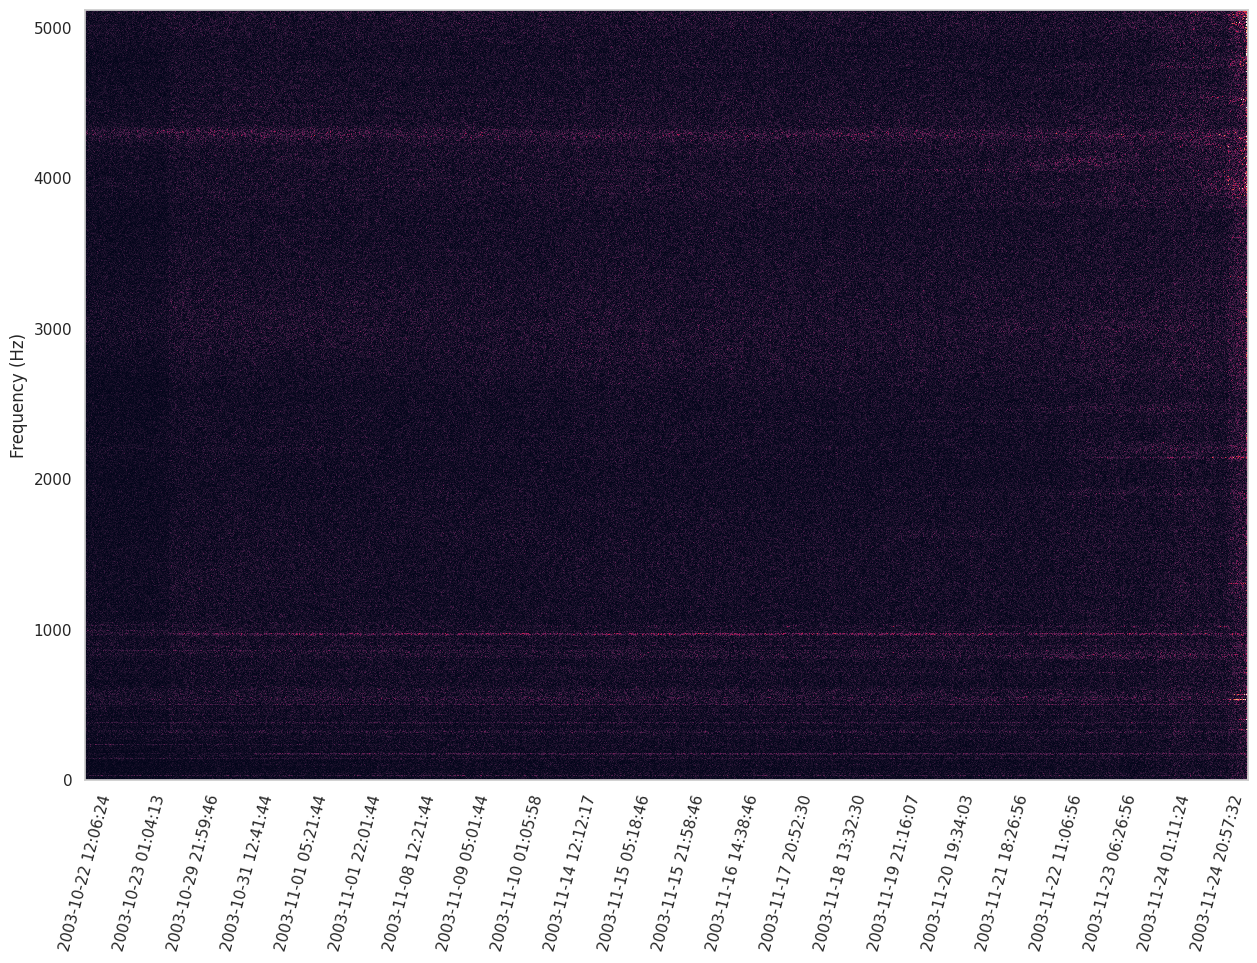

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.01) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

Try some other runs for the IMS data set and see what the spectrogram looks like!

In [16]:
folder_2nd = folder_raw_data / '2nd_test'
date_list = sorted(os.listdir(folder_2nd))
col_names = ['b1_ch1', 'b2_ch2', 'b3_ch3', 'b4_ch4']
df_spec, labels_dict = build_spectrogram_df_ims(folder_2nd, date_list, channel_name='b1_ch1', start_time=date_list[0], col_names=col_names)

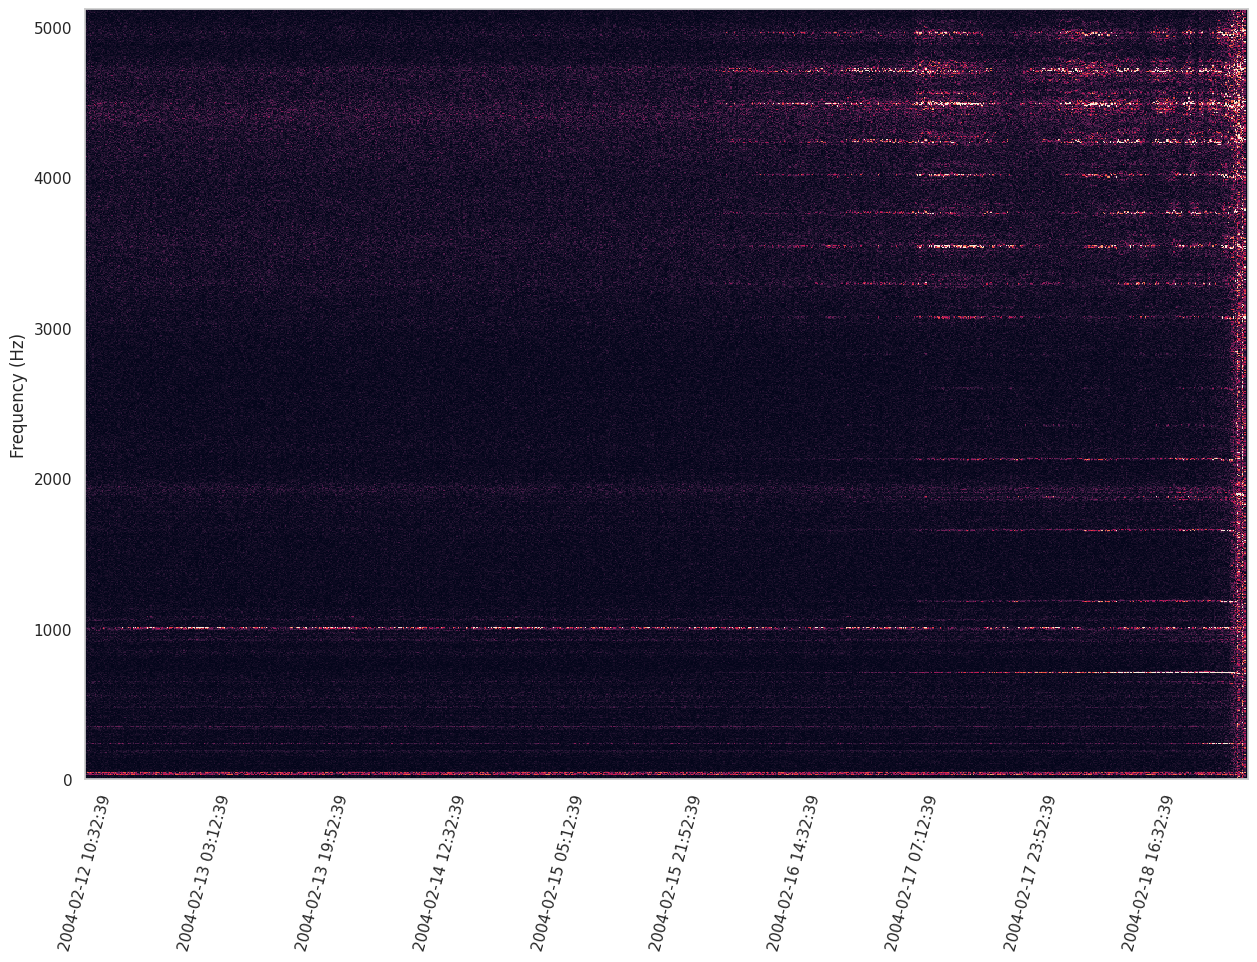

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.01) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

Inspect the `dataset_ims.py` (GitHub link [here](https://github.com/tvhahn/weibull-knowledge-informed-ml/blob/master/src/data/dataset_ims.py)) to see how we create spectrograms for each of the three runs in the IMS data set.

We do not train our neural network on the entire spectrogram, or on each individual FFT. Rather, we segment the spectrogram into 20 buckets. Each time step, with 10 bins, is an input into the model we will be training.

Here's a grapic of what the above spectrogram looks like after this "binning".

(10000, 984)


TypeError: Dimensions of C (20, 984) should be one smaller than X(984) and Y(21) while using shading='flat' see help(pcolormesh)

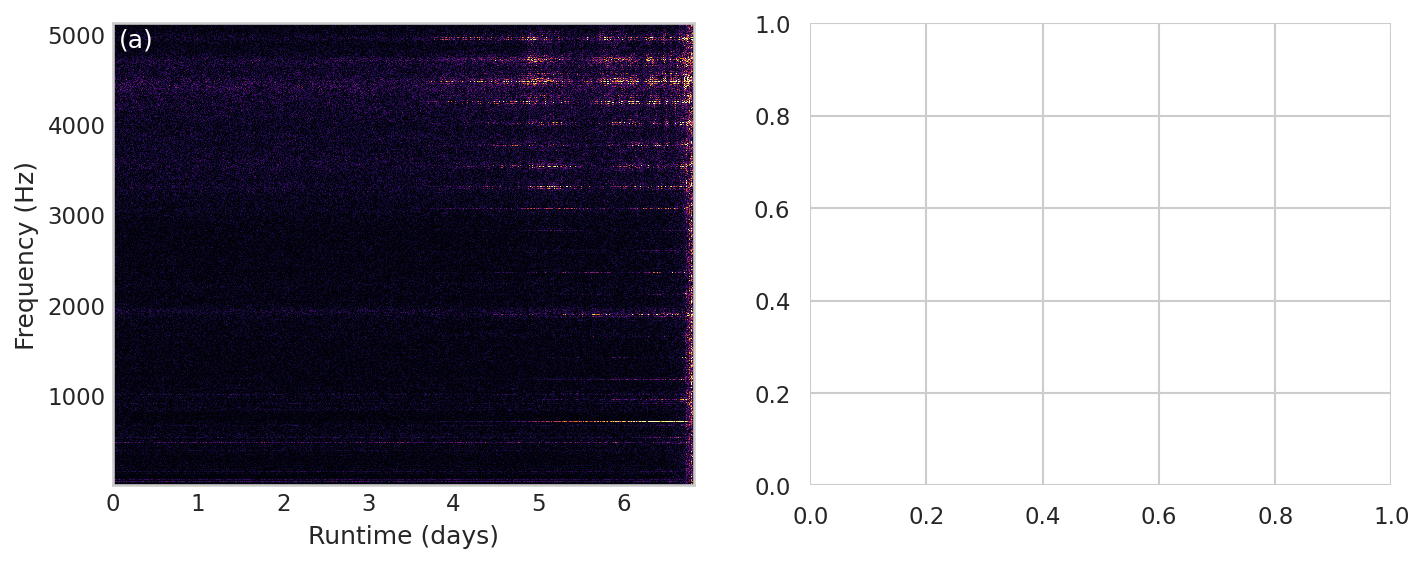

In [19]:
plot_spectogram_with_binned(
    df_spec,
    labels_dict,
    vmax_factor1=0.08,
    vmax_factor2=0.5,
    save_plot=False,
)

## 2.2 Build Spectrograms - PRONOSTIA
Similarly, we can build spectrograms for the runs in the PRONOSTIA (FEMTO) bearing data set. Inspect the `dataset_femto.py` (GitHub link [here](https://github.com/tvhahn/weibull-knowledge-informed-ml/blob/master/src/data/dataset_femto.py)) to see how we've created spectrograms for the runs in the data set.

In [22]:
folder_raw_data_train = (root_dir / 'data/raw' / "FEMTO/Learning_set/")

folder_indv_bearing = folder_raw_data_train / "Bearing1_1"
date_dict = create_date_dict(folder_indv_bearing)
df_spec, labels_dict = build_spectrogram_df_femto(folder_indv_bearing, date_dict, channel_name="acc_horz",)

FileNotFoundError: [Errno 2] No such file or directory: '/content/weibull-knowledge-informed-ml/data/raw/FEMTO/Learning_set/Bearing1_1'

In [26]:
ax[1].pcolormesh(
    days,
    np.arange(0, 21),
    # ...
)

TypeError: 'Axes' object is not subscriptable

In [25]:
# src/visualization/visualize_data.py

# ... (existing code)

def plot_spectogram_with_binned(
    df_spec,
    labels_dict,
    path_save_name="reports/figures/spectogram_with_binned.png",
    vmax_factor1=0.08,
    vmax_factor2=0.5,
    dpi=150,
    save_plot=False,
):
    # ... (existing code before pcolormesh call)

    ax[1].pcolormesh(
        days,
        np.arange(0, 21),
        # Slice the data array to remove the last column
        # This assumes the number of rows (20) is correct based on np.arange(0, 21)
        max_a[:, :-1],
        vmax=max_a.max() * vmax_factor2,
        cmap="viridis",
    )

    # ... (existing code after pcolormesh call)

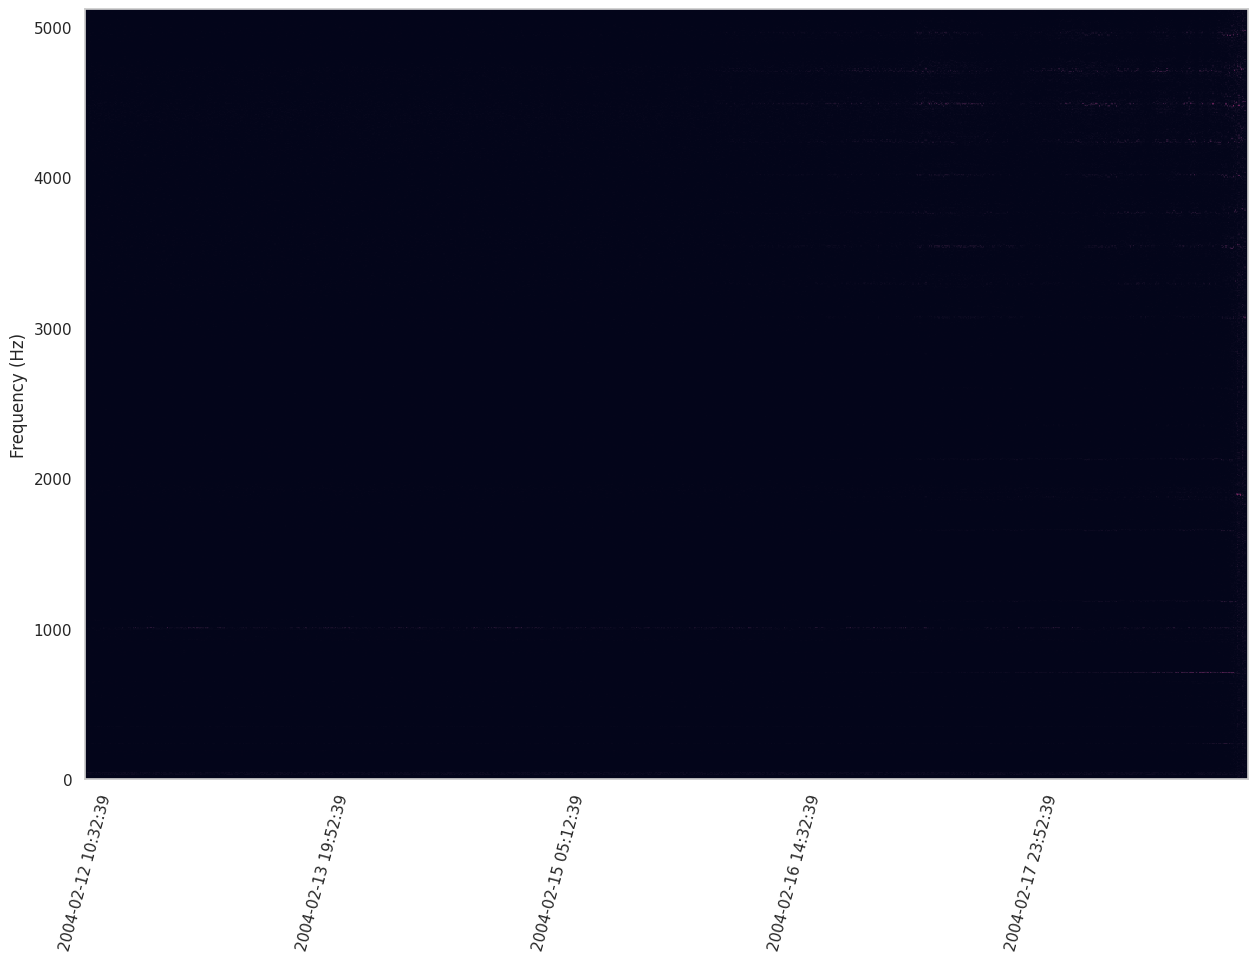

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.2) # need to add a vmax so that the color is not all dark

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::200]) # show every 200th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

# 3. Create Train/Val/Test Sets
This script will create the training, validation and testing data sets. Note: the data sets are included in the repo, so you don't need to run this step for this notebook.

In [27]:
!python /content/weibull-knowledge-informed-ml/src/data/make_dataset.py data/raw data/processed

2025-05-30 14:31:47,812 - __main__ - INFO - making final data set from raw data
Pronostia (FEMTO) data prep start.
Traceback (most recent call last):
  File "/content/weibull-knowledge-informed-ml/src/data/make_dataset.py", line 58, in <module>
    main()
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1442, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1363, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1226, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 794, in invoke
    return callback(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/weibull-knowledge-informed-ml/src/data/make_dataset.py", line 43, in main
    create

We have two functions that load the data sets -- `load_train_test_ims` for the IMS data sets, and `load_train_test_femto` for the PRONOSTIA data set.

Let's start by looking at the IMS data.

In [28]:
folder_data = root_dir / "data/processed/IMS/"

(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    x_train_2,
    y_train_2,
    x_train_3,
    y_train_3,
) = load_train_test_ims(folder_data)

In [29]:
print("x_train.shape,", x_train.shape)
print("y_train.shape,", y_train.shape)

x_train.shape, torch.Size([7304, 20])
y_train.shape, torch.Size([7304, 3])


As you can see, the individual data splits are saved as PyTorch tensors.

`y_train` has the following makeup:

In [30]:
y_train

tensor([[3.4531e+01, 7.7289e-01, 1.0147e+01],
        [1.8996e+01, 4.2518e-01, 2.5681e+01],
        [5.4583e+00, 7.9959e-01, 1.3681e+00],
        ...,
        [1.7812e+00, 3.9869e-02, 4.2896e+01],
        [1.5989e+01, 3.5788e-01, 2.8688e+01],
        [6.0903e+00, 8.9217e-01, 7.3611e-01]])

The second dimension in `y_train` is made up of three columns:

* Column 1: Run time since start (in days)
* Column 2: Percentage life remaining
* Column 3: Remaining useful life (in days)

We can now visualize the prepared data using the `ims_data_processed_fig` function.

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

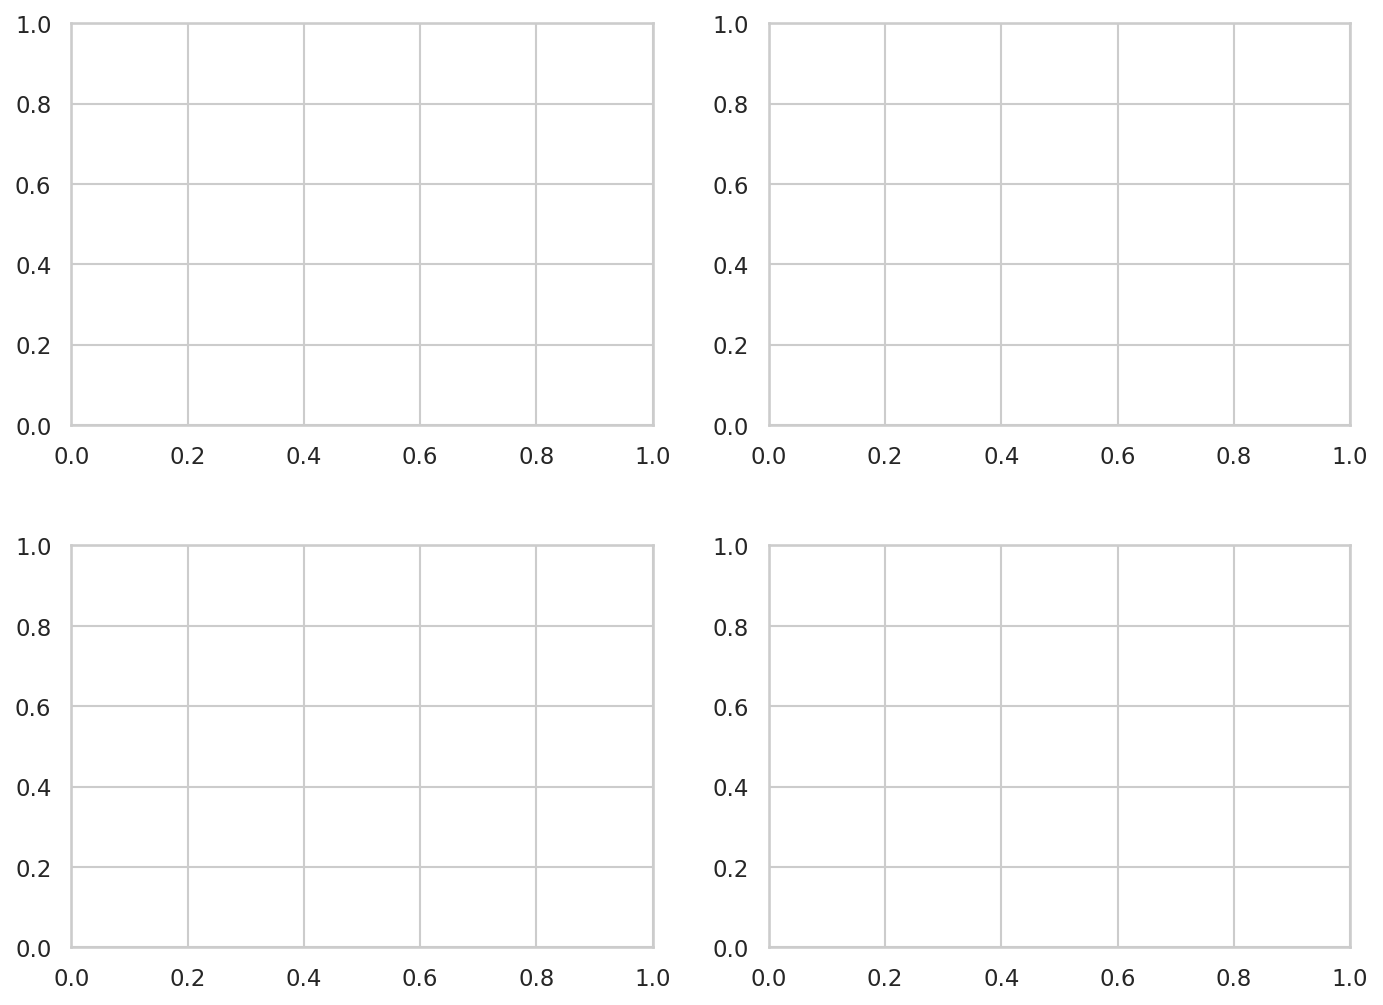

In [31]:
ims_data_processed_fig(
    folder_data,
    dpi=150,
    save_plot=False
)

In [32]:
# src/visualization/visualize_data.py

# ... (existing code)

def ims_data_processed_fig(
    folder_data_ims="data/processed/IMS/",
    path_save_name="reports/figures/ims_processed_data.pdf",
    dpi=150,
    save_plot=False,
):
    """
    Function to create plot of IMS processed data for three different runs.

    The function loads in the processed data for three runs and creates a plot
    showing the Remaining Useful Life (RUL) versus the run time since the start
    of the experiment. A horizontal line representing the threshold below which
    the experiment terminates is also shown.

    Parameters
    ----------
    folder_data_ims : str, optional
        Folder path where the IMS processed data is stored.
        The default is "data/processed/IMS/".
    path_save_name : str, optional
        Path and name to save the plot.
        The default is "reports/figures/ims_processed_data.pdf".
    dpi : int, optional
        DPI for the saved plot.
        The default is 150.
    save_plot : bool, optional
        Whether to save the plot. The default is False.
    """

    (
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        x_train_2,
        y_train_2,
        x_train_3,
        y_train_3,
    ) = load_train_test_ims(folder_data_ims)

    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    axes_list = axes.ravel()  # flatten axes list

    ###### TRAINING DATA ######
    # plot training data - Run 1
    axes_list[0].plot(
        y_train[:, 0], y_train[:, 2], label="Train 1 (Run 1)", color="steelblue"
    )
    # plot training data - Run 2
    axes_list[0].plot(
        y_train_2[:, 0], y_train_2[:, 2], label="Train 2 (Run 2)", color="orange"
    )
    # plot training data - Run 3
    axes_list[0].plot(
        y_train_3[:, 0], y_train_3[:, 2], label="Train 3 (Run 3)", color="red"
    )

    axes_list[0].axhline(
        y=0.0, color="k", linestyle="--", label="End of Life Threshold"
    )  # horizontal line at end of life
    axes_list[0].legend(loc="center right", bbox_to_anchor=(1.35, 0.5))
    axes_list[0].set_ylabel("RUL (Days)")
    axes_list[0].set_title("Remaining Useful Life")

    ###### VALIDATION DATA #####
    # plot validation data - Run 1
    axes_list[1].plot(
        y_val[:, 0], y_val[:, 2], label="Validation 1 (Run 1)", color="steelblue"
    )

    axes_list[1].axhline(y=0.0, color="k", linestyle="--")
    axes_list[1].legend(loc="center right", bbox_to_anchor=(1.35, 0.5))
    axes_list[1].set_ylabel("RUL (Days)")

    ###### TEST DATA #####
    # plot test data - Run 2
    axes_list[2].plot(
        y_test[:, 0], y_test[:, 2], label="Test 1 (Run 2)", color="orange"
    )

    axes_list[2].axhline(y=0.0, color="k", linestyle="--")
    axes_list[2].legend(loc="center right", bbox_to_anchor=(1.35, 0.5))
    axes_list[2].set_ylabel("RUL (Days)")
    axes_list[2].set_xlabel("Run Time (Days)")

    for ax in axes_list:
        # Changed from ax.grid(b=None) to ax.grid(visible=False)
        ax.grid(visible=False)

    plt.tight_layout()  # adjust the spacing

    if save_plot:
        plt.savefig(path_save_name, dpi=dpi, bbox_inches="tight")

    plt.show()

# ... (rest of the file)

Now let's look at the PRONOSTIA data.

You'll see that there are many more runs in the PRONOSTIA (FEMTO) data set, and we don't even use them all.

In [33]:
folder_data = root_dir / "data/processed/FEMTO/"

(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    x_train1_1,
    y_train1_1,
    x_train2_1,
    y_train2_1,
    x_train3_1,
    y_train3_1,
    x_val1_2,
    y_val1_2,
    x_val2_2,
    y_val2_2,
    x_val3_2,
    y_val3_2,
    x_test1_3,
    y_test1_3,
    x_test2_3,
    y_test2_3,
    x_test3_3,
    y_test3_3,
) = load_train_test_femto(folder_data)

print("x_train.shape,", x_train.shape)
print("y_train.shape,", y_train.shape)

x_train.shape, torch.Size([4222, 20])
y_train.shape, torch.Size([4222, 3])


Again, let's visualize the various cuts using the `femto_data_processed_fig` function.

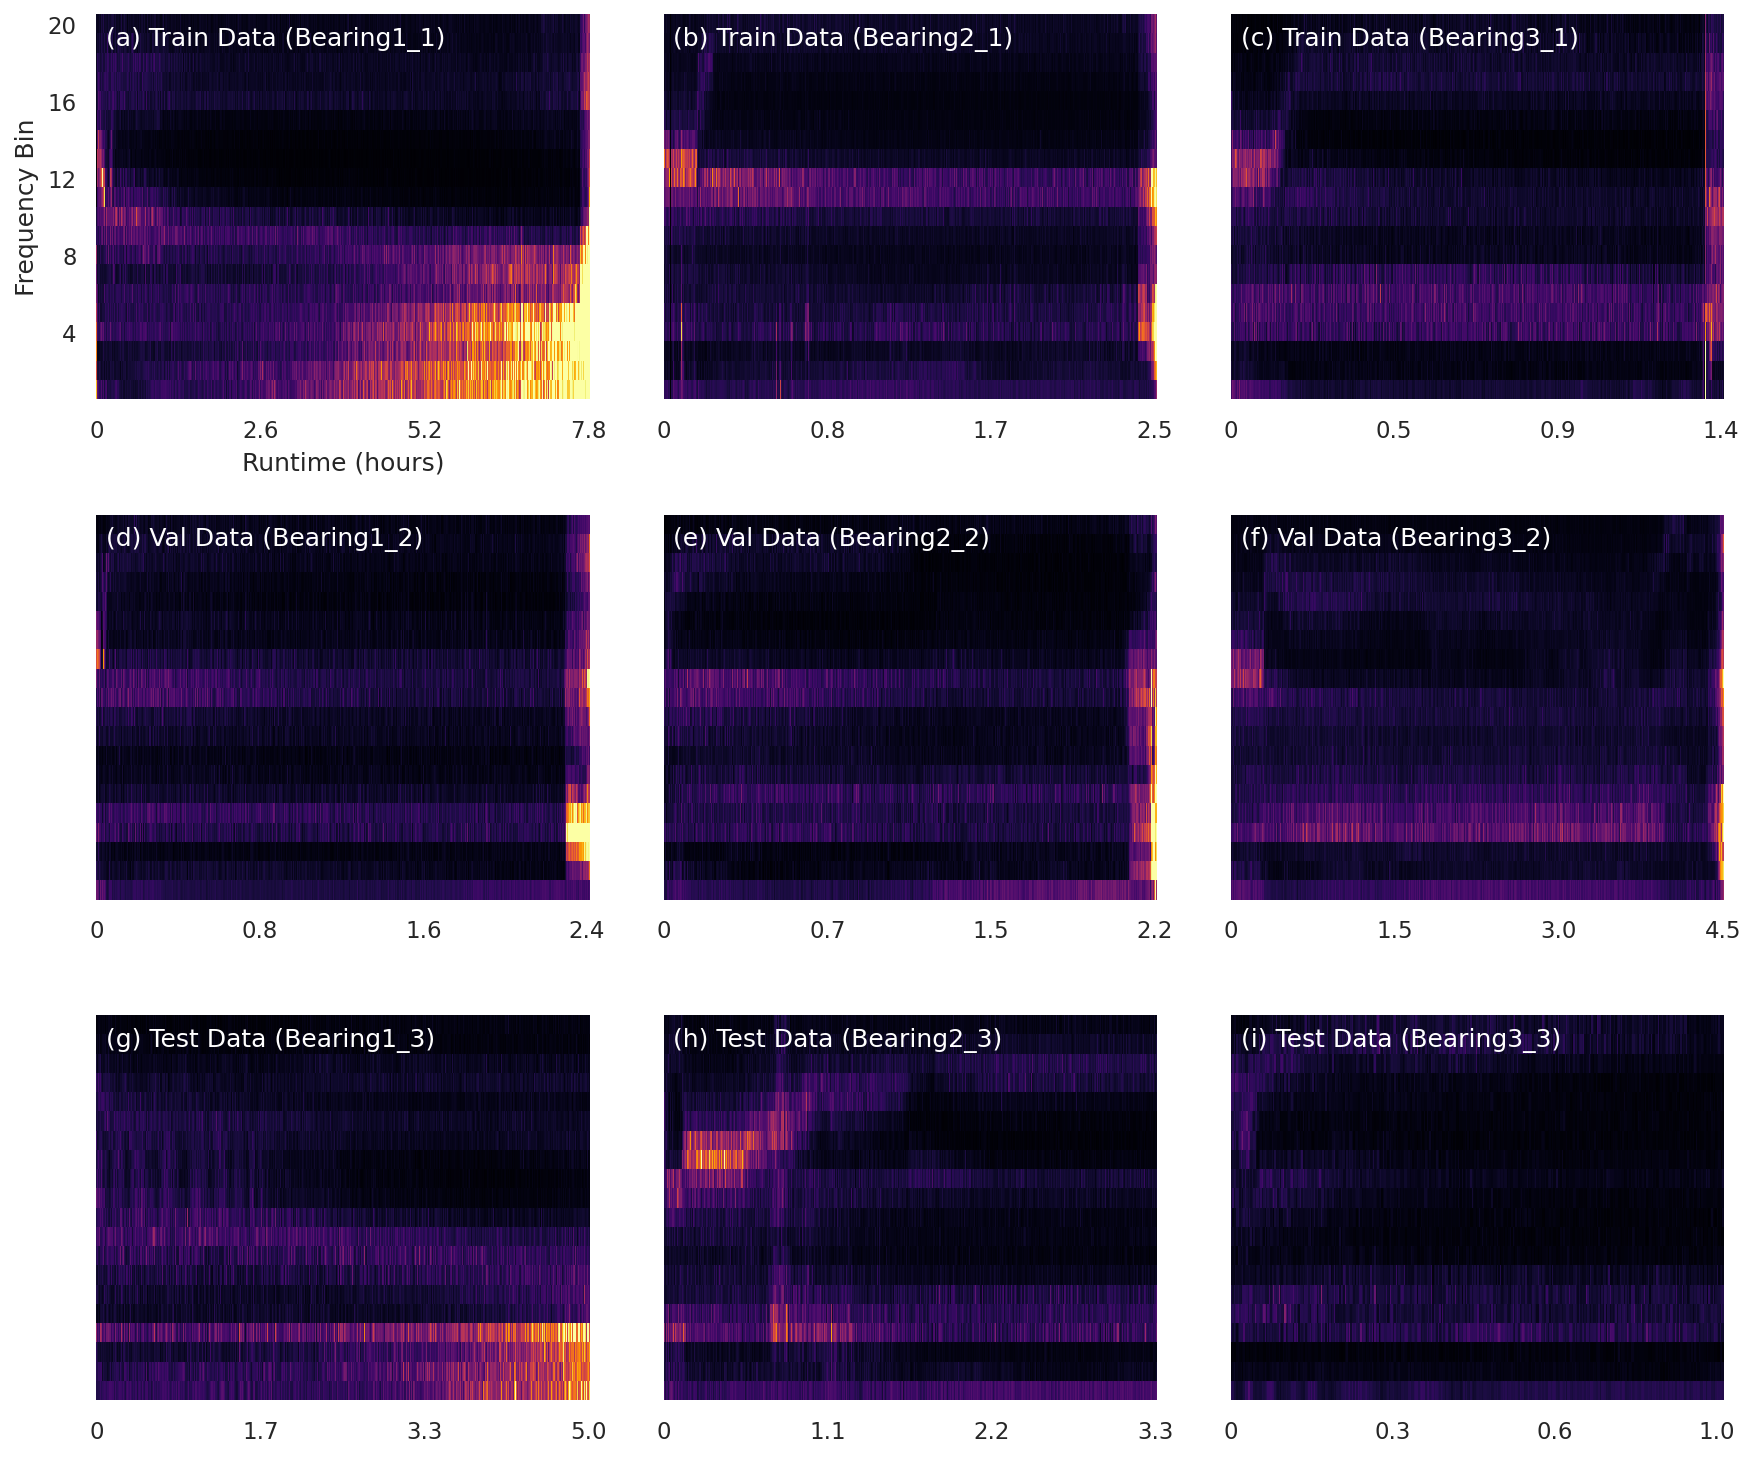

In [34]:
femto_data_processed_fig(
    folder_data,
    dpi=150,
    vmax_val=0.15,
    save_plot=False
)

# 4. Train Models with a Random Search
We can perform a random search across a wide variety of feed forward neural networks by calling on the `train_models.py` script.

Here's an example of what one of the models that we'll train could look like:

<br>
<div style="text-align: center; ">
<figure>
  <img src="https://github.com/tvhahn/weibull-knowledge-informed-ml/blob/master/reports/figures/model_example.svg?raw=1" alt="neural network example" style="background:none; border:none; box-shadow:none; text-align:center" width="800px"/>
  <div style="text-align: center; ">
  <br>
  <figcaption style="color:grey; font-size:smaller">Many simple feed-forward neural networks are used in the random search.</figcaption>
  </div>
</figure>
</div>

Let's perform a small random search -- two random search iterations.

In [35]:
!python /content/weibull-knowledge-informed-ml/src/models/train_models.py \
--data_set ims \
--path_data data/processed \
--proj_dir /content/weibull-knowledge-informed-ml/ \
--random_search_iter 2

Assume on local compute
folder_path --> /content/weibull-knowledge-informed-ml
#### FOLDER_PATH: /content/weibull-knowledge-informed-ml
load IMS data data/processed/IMS
Running on CPU
mse
Traceback (most recent call last):
  File "/content/weibull-knowledge-informed-ml/src/models/train_models.py", line 643, in <module>
    df, net = train(
              ^^^^^^
  File "/content/weibull-knowledge-informed-ml/src/models/train_models.py", line 438, in train
    early_stopping = EarlyStopping(
                     ^^^^^^^^^^^^^^
  File "/content/weibull-knowledge-informed-ml/src/models/utils.py", line 49, in __init__
    self.val_loss_min = np.Inf
                        ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/__init__.py", line 397, in __getattr__
    raise AttributeError(
AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.. Did you mean: 'inf'?


The results are saved in the `models` folder. The parameters, and performance, of each model in the random search is saved in a csv in the `models/interim/results_csv_ims` or `models/interim/results_csv_femto` folder. Let's take a look at one of these csvs.

In [36]:
folder_results_csv = root_dir / 'models/interim/results_csv_ims'

# get a list of all file names in folder_results_csv
files = os.listdir(folder_results_csv)
file_list = [folder_results_csv / filename for filename in files if filename.endswith('.csv')]

# print the path of the first csv in file_list
print(file_list[0])

df = pd.read_csv(file_list[0])
df.head()

IndexError: list index out of range

In [37]:
!python /content/weibull-knowledge-informed-ml/src/models/train_models.py \
--data_set ims \
--path_data data/processed \
--proj_dir /content/weibull-knowledge-informed-ml/ \
--random_search_iter 50  # Increased random search iterations

Assume on local compute
folder_path --> /content/weibull-knowledge-informed-ml
#### FOLDER_PATH: /content/weibull-knowledge-informed-ml
load IMS data data/processed/IMS
Running on CPU
mse
Traceback (most recent call last):
  File "/content/weibull-knowledge-informed-ml/src/models/train_models.py", line 643, in <module>
    df, net = train(
              ^^^^^^
  File "/content/weibull-knowledge-informed-ml/src/models/train_models.py", line 438, in train
    early_stopping = EarlyStopping(
                     ^^^^^^^^^^^^^^
  File "/content/weibull-knowledge-informed-ml/src/models/utils.py", line 49, in __init__
    self.val_loss_min = np.Inf
                        ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/__init__.py", line 397, in __getattr__
    raise AttributeError(
AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.. Did you mean: 'inf'?


In [38]:
folder_results_csv = root_dir / 'models/interim/results_csv_ims'

# get a list of all file names in folder_results_csv
files = os.listdir(folder_results_csv)
file_list = [folder_results_csv / filename for filename in files if filename.endswith('.csv')]

# Check if the file_list is empty before trying to access an element
if not file_list:
    print(f"No CSV files found in the directory: {folder_results_csv}")
    print("Please ensure the train_models.py script ran successfully and produced results.")
else:
    # print the path of the first csv in file_list
    print(file_list[0])

    df = pd.read_csv(file_list[0])
    display(df.head()) # Use display to show the dataframe in a notebook

No CSV files found in the directory: /content/weibull-knowledge-informed-ml/models/interim/results_csv_ims
Please ensure the train_models.py script ran successfully and produced results.


In the above dataframe, you'll note that there are no test results. This is so that we do not go about "fishing" for a good result. Only until we've trained all the models can we check the performance of the models so as to not bias our results.

Each model trained during the random search also has an associated learning curve created for it. This way you can see how the model trained -- to make sure the training makes sense.

Let's load one of these learning curves.

In [39]:
folder_results_curve = root_dir / 'models/interim/learning_curves_ims'

files = os.listdir(folder_results_curve)
file_list = [folder_results_curve / filename for filename in files if filename.endswith('.png')]


Image(filename=str(file_list[1]), width=900) # use from IPython.display import Image

IndexError: list index out of range

In [40]:
folder_results_curve = root_dir / 'models/interim/learning_curves_ims'

files = os.listdir(folder_results_curve)
file_list = [folder_results_curve / filename for filename in files if filename.endswith('.png')]

# Check if the file_list is empty before trying to access an element
if not file_list:
    print(f"No learning curve PNG files found in the directory: {folder_results_curve}")
    print("Please ensure the train_models.py script ran successfully and produced learning curves.")
else:
    # Use display from IPython.display
    from IPython.display import Image, display
    # print the path of the first png in file_list (or another index if needed)
    # Access the first element (index 0) instead of index 1 to avoid IndexError if only one file exists
    print(f"Displaying learning curve: {file_list[0]}")
    display(Image(filename=str(file_list[0]), width=900))

No learning curve PNG files found in the directory: /content/weibull-knowledge-informed-ml/models/interim/learning_curves_ims
Please ensure the train_models.py script ran successfully and produced learning curves.


# 5. Summarize Results
All the models from the random search have been trained. Now we need to find the best performing models and filter out the poorly performing ones.

The `summarize_model_results.py` script will take all the trained models (and the result csvs) and summarize the results into a number of consolidated csvs. These results will then be used to produce some nice charts.

* `{femto or ims}_correlation_results.csv` - the correlation between loss functions and the test $R^2$ for models passing the filter criteria
* `{femto or ims}_count_results.csv` - the count of the types of loss functions from models passing the filter criteria
* `{femto or ims}_early_stop_summary_stats.csv` - count of the early stop times for models
* `{femto or ims}_results_filtered.csv` - the results table after filtering, with all columns
* `{femto or ims}_results_summary_all.csv.gz` - the results table before filtering, with all columns

You can run the `summarize_model_results.py` below (uncomment the cell), but you may not have enough models trained to get passed the filtering criteria. Because of that, we'll load the `ims_results_summary_all.csv.gz` as a demonstration to see how the filtering was carried out.

In [41]:
# !python /content/weibull-knowledge-informed-ml/src/models/summarize_model_results.py --data_set ims
# !python /content/weibull-knowledge-informed-ml/src/models/summarize_model_results.py --data_set femto

Load the `ims_results_summary_all.csv.gz`.

In [42]:
csv_results_all = root_dir / 'models/final' / 'ims_results_summary_all.csv.gz'

df = pd.read_csv(csv_results_all, compression='gzip',)
df.head()

date_time data_set     loss_func  rnd_seed_input  \
0  2021_04_05_12:13:49      ims           mse         2031227   
1  2021_04_05_12:13:49      ims          rmse         2031227   
2  2021_04_05_12:13:49      ims         rmsle         2031227   
3  2021_04_05_12:13:49      ims   weibull_mse         2031227   
4  2021_04_05_12:13:49      ims  weibull_rmse         2031227   

   rnd_search_iter  rnd_search_iter_no  beta        eta  epochs  patience  \
0             3000                   0   2.0  63.893981    2000        50   
1             3000                   0   2.0  63.893981    2000        50   
2             3000                   0   2.0  63.893981    2000        50   
3             3000                   0   2.0  63.893981    2000        50   
4             3000                   0   2.0  63.893981    2000        50   

   ...  prob_drop_true  mse  rmse  rmsle  weibull_mse  weibull_rmse  \
0  ...               1    1     0      0            0             0   
1  ...               1    0     1      0            0             0   
2  ...               1    0     0      1            0             0   
3  ...               1    0     0      0            1             0   
4  ...               1    0     0      0            0             1   

   weibull_rmsle  weibull_only_mse  weibull_only_rmse  weibull_only_rmsle  
0              0                 0                  0                   0  
1              0                 0                  0                   0  
2              0                 0                  0                   0  
3              0                 0                  0                   0  
4              0                 0                  0                   0  

[5 rows x 49 columns]

There is a lot going on in the `df` results dataframe. Here are all the column names:

In [43]:
df.columns

Index(['date_time', 'data_set', 'loss_func', 'rnd_seed_input',
       'rnd_search_iter', 'rnd_search_iter_no', 'beta', 'eta', 'epochs',
       'patience', 'early_stop_delay', 'batch_size', 'learning_rate',
       'lambda_mod', 'n_layers', 'n_units', 'prob_drop', 'epoch_stopped_on',
       'loss_mse_train', 'loss_rmse_train', 'loss_mae_train',
       'loss_rmsle_train', 'r2_train', 'loss_mse_val', 'loss_rmse_val',
       'loss_mae_val', 'loss_rmsle_val', 'r2_val', 'r2_val_avg',
       'r2_train_2_avg', 'r2_train_3_avg', 'date_time_seed',
       'model_checkpoint_name', 'r2_test', 'r2_test_avg', 'loss_mae_test',
       'loss_rmse_test', 'loss_rmsle_test', 'weibull_loss', 'prob_drop_true',
       'mse', 'rmse', 'rmsle', 'weibull_mse', 'weibull_rmse', 'weibull_rmsle',
       'weibull_only_mse', 'weibull_only_rmse', 'weibull_only_rmsle'],
      dtype='object')

How many unique model architectures?

In [44]:
print("No. unique model architectures:", len(df["date_time_seed"].unique()))
print("No. unique models (includes unique loss functions):", len(df["date_time_seed"]))

No. unique model architectures: 1078
No. unique models (includes unique loss functions): 9377


## 5.1 Example of Filtering Out Poorly Performing Models
We performed a large random search. Naturally, many of the models will be of low quality. To filter out the low quality models we will establish a threshold criteria -- models above the threshold we'll keep, and models below will be removed from further analysis.

There are a number of way to filter out poorly performing models. We've chosen to use $R^2$ and RMSE, and we will sort the results by the test $R^2$.

In [45]:
# Filter parameters
R2_BOUND = 0.2  # greater than
RMSE_BOUND = 0.35  # less than
SORT_BY = "r2_test"  # metric used to evaluate results

In [46]:
# filter results and select top models
loss_func_list = df["loss_func"].unique()

sort_by = SORT_BY

dfr = df[
    (df["r2_test"] > R2_BOUND)
    & (df["loss_rmse_test"] < RMSE_BOUND)
    & (df["r2_train"] > R2_BOUND)
    & (df["loss_rmse_train"] < RMSE_BOUND)
    & (df["r2_val"] > R2_BOUND)
    & (df["loss_rmse_val"] < RMSE_BOUND)
    & (df["beta"] == 2.0)
][:]

dfr = (
    dfr.groupby(["date_time_seed"])
    .apply(lambda x: x.sort_values([sort_by], ascending=False))
    .reset_index(drop=True)
)

dfr = (dfr.groupby(["date_time_seed"]).head(1).sort_values(by=sort_by, ascending=False))

In [47]:
dfr.head()

date_time data_set      loss_func  rnd_seed_input  \
3478  2021_04_05_17:06:26      ims   weibull_rmse         3405377   
3671  2021_04_05_17:28:24      ims  weibull_rmsle         6474908   
331   2021_04_05_13:09:38      ims  weibull_rmsle         8095234   
3619  2021_04_05_17:20:33      ims  weibull_rmsle         3860637   
3047  2021_04_05_16:20:38      ims          rmsle         5826015   

      rnd_search_iter  rnd_search_iter_no  beta        eta  epochs  patience  \
3478             3000                  14   2.0  63.893981    2000        50   
3671             3000                  13   2.0  63.893981    2000        50   
331              3000                  13   2.0  63.893981    2000        50   
3619             3000                   6   2.0  63.893981    2000        50   
3047             3000                   6   2.0  63.893981    2000        50   

      ...  prob_drop_true  mse  rmse  rmsle  weibull_mse  weibull_rmse  \
3478  ...               0    0     0      0            0             1   
3671  ...               0    0     0      0            0             0   
331   ...               1    0     0      0            0             0   
3619  ...               1    0     0      0            0             0   
3047  ...               0    0     0      1            0             0   

      weibull_rmsle  weibull_only_mse  weibull_only_rmse  weibull_only_rmsle  
3478              0                 0                  0                   0  
3671              1                 0                  0                   0  
331               1                 0                  0                   0  
3619              1                 0                  0                   0  
3047              0                 0                  0                   0  

[5 rows x 49 columns]

In [48]:
print("No. unique model architectures:", len(dfr["date_time"].unique()))
print("No. unique models (includes unique loss functions):", len(dfr["date_time"]))

No. unique model architectures: 727
No. unique models (includes unique loss functions): 775


You can inspect the `summarize_model_results.py` to see how the rest of the result tables are created.

## 5.2 Visualize Results
With all the results tables created (and saved as csvs), we can visualize some results.

In [49]:
# csv result locations
path_results = root_dir / "models/final/"
path_save_loc = root_dir / "reports/figures/"

Here's the figure for the loss functions, ranked by how frequently they appeared in the results, after the poorly performing models were filtered out.

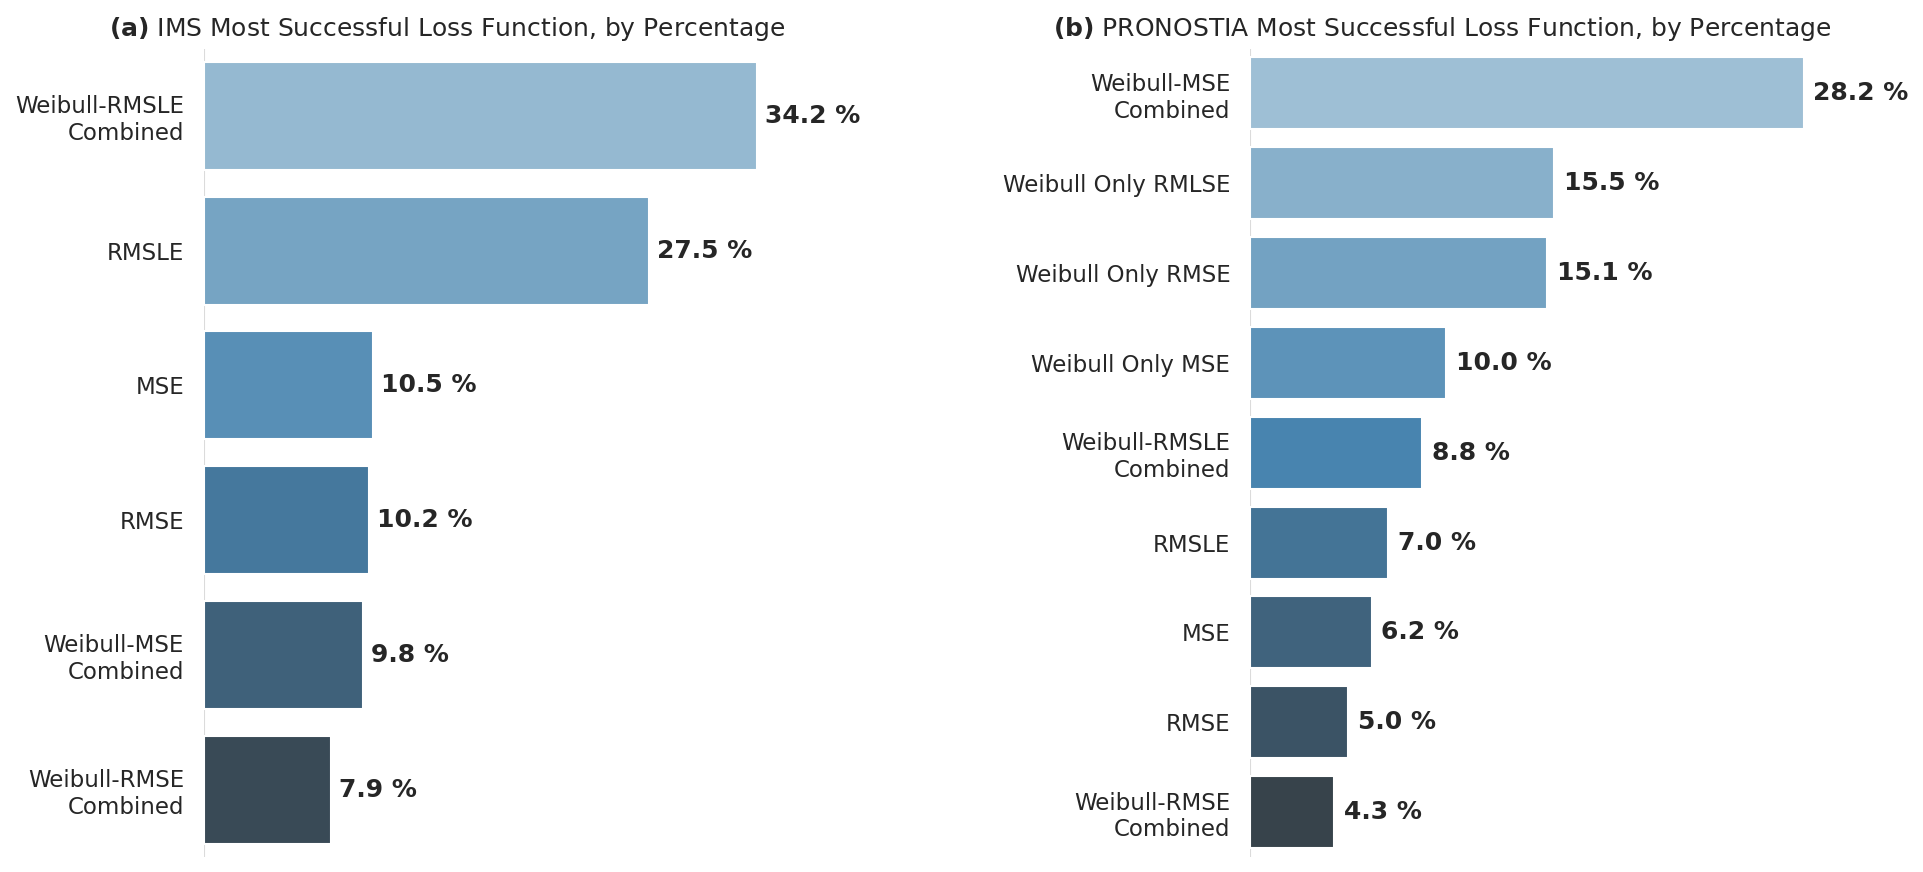

In [50]:
loss_function_percentage_fig(
    path_results / "ims_count_results.csv",
    path_results / "femto_count_results.csv",
    dpi=150,
    save_plot=False
)

Here's the figure showing the point-biserial correlation coefficient between each loss function and the test $R^2$. All correlations were statistically significant (P-value < 0.05) except where otherwise noted.

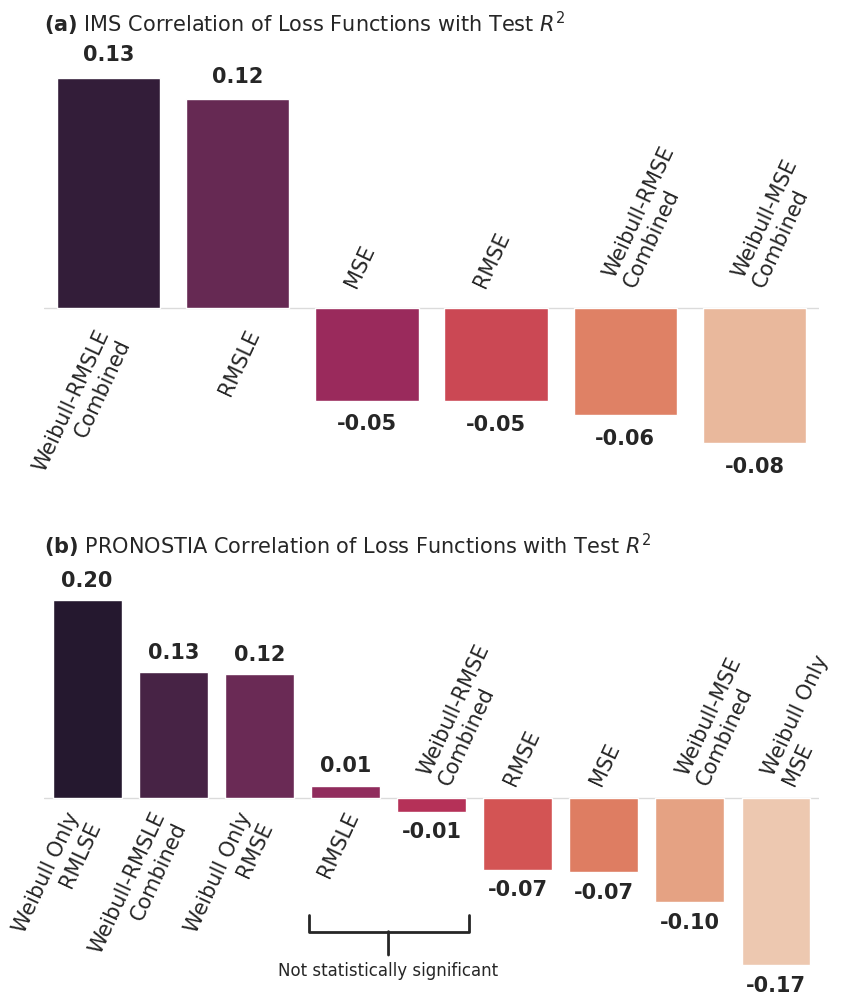

In [51]:
loss_function_correlation_fig(
    path_results / "ims_correlation_results.csv",
    path_results / "femto_correlation_results.csv",
    dpi=300,
    save_plot=False
)

Seeing how the early stopping worked for all the models we trained is also interesting.

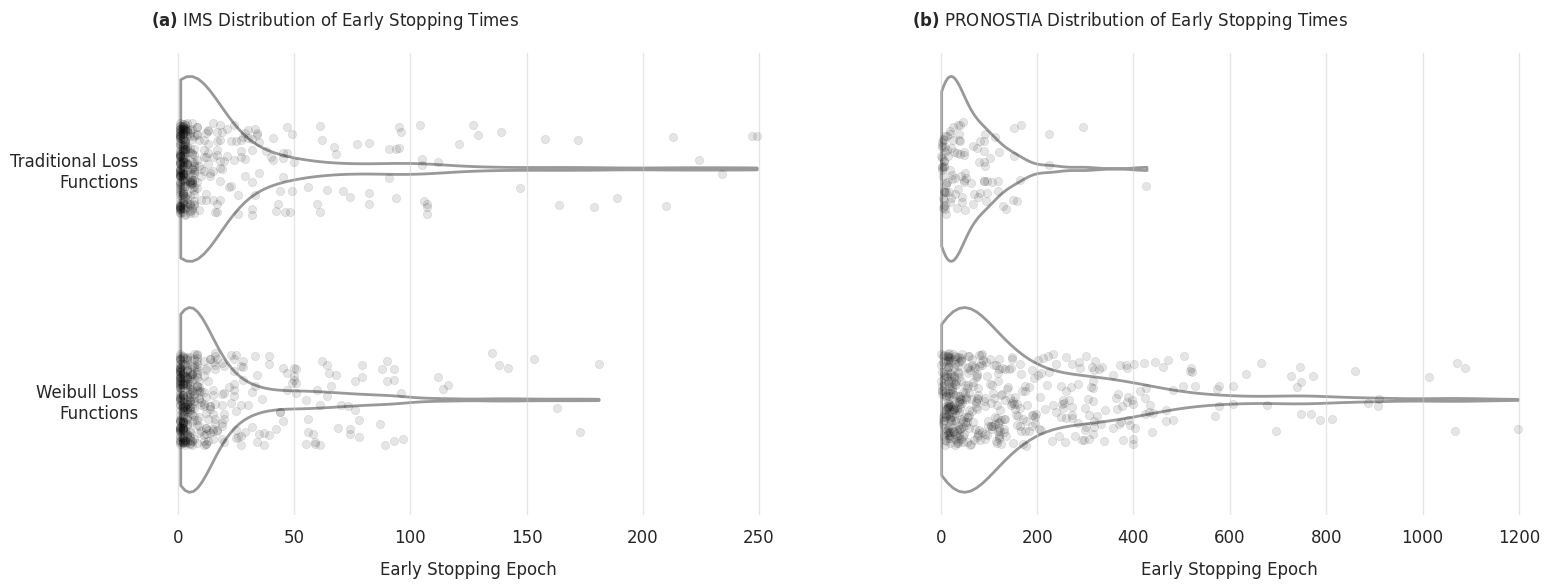

In [52]:
early_stop_distribution_fig(
    path_results / "ims_results_filtered.csv",
    path_results / "femto_results_filtered.csv",
    figsize=(18,6),
    save_plot=False,
    dpi=150,
)

In the above plots, each dot represents when one model quit training due to early stopping. The width of the violin shape represents the relative frequency of early stopping times.

Finally, let's take the "top" models from the IMS and PRONOSTIA experiments and see what the RUL trends look like.

Check out the paper to read the analysis of the results!

In [53]:
# create the plots of the top models with predictions on them
folder_data_ims = root_dir / "data/processed/IMS/"
folder_data_femto = root_dir / "data/processed/FEMTO/"

In [54]:
# need model for loading checkpoint
copyfile(path_results / "top_models_femto/model.py", "model.py")

'model.py'

In [65]:
# make PRONOSTIA (FEMTO) rul plots
df_top = pd.read_csv(root_dir / "models/final/femto_results_filtered.csv")
model_name = df_top["model_checkpoint_name"][0]  # select top model

femto_results_rul_fig(
    root_dir / "models/final/top_models_femto",
    model_name,
    folder_data_femto,
    path_save_loc / "femto_rul_results.pdf",
    save_plot=False,
    dpi=150,
)

os.remove("model.py")  # delete model.py that was copied to root dir

Running on CPU


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.ModuleList was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ModuleList])` or the `torch.serialization.safe_globals([ModuleList])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [66]:
# need model for loading checkpoint
copyfile(path_results / "top_models_femto/model.py", "model.py")
# import the Net class after copying the file
from model import Net
import torch
import os
import pandas as pd
import torch.serialization
import torch.nn as nn # Import nn to access ModuleList and potentially Dropout

# Temporarily allowlist the custom class 'Net' and necessary built-in PyTorch modules for loading
# Add ModuleList to the list of safe globals
torch.serialization.add_safe_globals([Net, nn.ModuleList, nn.Dropout]) # Added nn.ModuleList and nn.Dropout

# make PRONOSTIA (FEMTO) rul plots
df_top = pd.read_csv(root_dir / "models/final/femto_results_filtered.csv")
model_name = df_top["model_checkpoint_name"][0]  # select top model

# After allowing, call the function that uses torch.load
femto_results_rul_fig(
    root_dir / "models/final/top_models_femto",
    model_name,
    folder_data_femto,
    path_save_loc / "femto_rul_results.pdf",
    save_plot=False,
    dpi=150,
)

# The add_safe_globals is a persistent change within the process.
# If you need to revert, you would manage the globals list, but for this case,
# leaving it added is acceptable since the custom class is defined here.
# You could potentially remove it after loading if necessary for stricter security.

os.remove("model.py")  # delete model.py that was copied to root dir

Running on CPU


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.linear.Linear was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Linear])` or the `torch.serialization.safe_globals([Linear])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [67]:
# src/visualization/visualize_results.py

# ... (existing imports and function definitions)

def femto_results_rul_fig(
    path_top_model_folder="models/final/top_models_femto",
    top_model_name="top_model.pth",
    folder_data_femto="data/processed/FEMTO/",
    path_save_name="reports/figures/femto_rul_results.pdf",
    dpi=150,
    save_plot=False,
):
    """
    Function to create plot of FEMTO processed data and the top model prediction.

    The function loads in the processed data for the test cuts and the top
    trained model. It then makes predictions on the test data and creates
    a plot showing the Remaining Useful Life (RUL) versus the run time since
    the start of the experiment. A horizontal line representing the threshold
    below which the experiment terminates is also shown.

    Parameters
    ----------
    path_top_model_folder : str or Path, optional
        Folder path where the top model checkpoint is stored.
        The default is "models/final/top_models_femto".
    top_model_name : str, optional
        Name of the top model checkpoint file. The default is "top_model.pth".
    folder_data_femto : str, optional
        Folder path where the FEMTO processed data is stored.
        The default is "data/processed/FEMTO/".
    path_save_name : str, optional
        Path and name to save the plot.
        The default is "reports/figures/femto_rul_results.pdf".
    dpi : int, optional
        DPI for the saved plot.
        The default is 150.
    save_plot : bool, optional
        Whether to save the plot. The default is False.
    """

    # ... (existing code before torch.load)

    # Load the model checkpoint, explicitly setting weights_only=False
    # This is necessary for checkpoints saved before PyTorch 2.6 or
    # containing custom classes or built-in modules not in the default
    # weights_only allowlist. Ensure you trust the source of the checkpoint.
    net = torch.load(path_top_model_folder / top_model_name, map_location=device, weights_only=False)

    # ... (rest of the function)


# ... (rest of the file)

In [68]:
# need model for loading checkpoint
copyfile(path_results / "top_models_femto/model.py", "model.py")
# import the Net class after copying the file
from model import Net
import torch
import os
import pandas as pd

# make PRONOSTIA (FEMTO) rul plots
df_top = pd.read_csv(root_dir / "models/final/femto_results_filtered.csv")
model_name = df_top["model_checkpoint_name"][0]  # select top model

femto_results_rul_fig(
    root_dir / "models/final/top_models_femto",
    model_name,
    folder_data_femto,
    path_save_loc / "femto_rul_results.pdf",
    save_plot=False,
    dpi=150,
)

os.remove("model.py")  # delete model.py that was copied to root dir

NameError: name 'device' is not defined

In [63]:
# need model for loading checkpoint
copyfile(path_results / "top_models_femto/model.py", "model.py")
# import the Net class after copying the file
from model import Net
import torch
import os
import pandas as pd
import torch.serialization

# Temporarily allowlist the custom class 'Net' for loading
torch.serialization.add_safe_globals([Net])

# make PRONOSTIA (FEMTO) rul plots
df_top = pd.read_csv(root_dir / "models/final/femto_results_filtered.csv")
model_name = df_top["model_checkpoint_name"][0]  # select top model

# After allowing, call the function that uses torch.load
femto_results_rul_fig(
    root_dir / "models/final/top_models_femto",
    model_name,
    folder_data_femto,
    path_save_loc / "femto_rul_results.pdf",
    save_plot=False,
    dpi=150,
)

# The add_safe_globals is a persistent change within the process.
# If you need to revert, you would manage the globals list, but for this case,
# leaving it added is acceptable since the custom class is defined here.
# You could potentially remove it after loading if necessary for stricter security.

os.remove("model.py")  # delete model.py that was copied to root dir

Running on CPU


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.dropout.Dropout was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Dropout])` or the `torch.serialization.safe_globals([Dropout])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [64]:
# need model for loading checkpoint
copyfile(path_results / "top_models_femto/model.py", "model.py")
# import the Net class after copying the file
from model import Net
import torch
import os
import pandas as pd
import torch.serialization
import torch.nn as nn # Import nn to access Dropout

# Temporarily allowlist the custom class 'Net' and the built-in 'Dropout' for loading
torch.serialization.add_safe_globals([Net, nn.Dropout]) # Added nn.Dropout

# make PRONOSTIA (FEMTO) rul plots
df_top = pd.read_csv(root_dir / "models/final/femto_results_filtered.csv")
model_name = df_top["model_checkpoint_name"][0]  # select top model

# After allowing, call the function that uses torch.load
femto_results_rul_fig(
    root_dir / "models/final/top_models_femto",
    model_name,
    folder_data_femto,
    path_save_loc / "femto_rul_results.pdf",
    save_plot=False,
    dpi=150,
)

# The add_safe_globals is a persistent change within the process.
# If you need to revert, you would manage the globals list, but for this case,
# leaving it added is acceptable since the custom class is defined here.
# You could potentially remove it after loading if necessary for stricter security.

os.remove("model.py")  # delete model.py that was copied to root dir

Running on CPU


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.ModuleList was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ModuleList])` or the `torch.serialization.safe_globals([ModuleList])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [57]:
# need model for loading checkpoint
copyfile(path_results / "top_models_femto/model.py", "model.py")
# import the Net class after copying the file
from model import Net
import torch
import os
import pandas as pd

# make PRONOSTIA (FEMTO) rul plots
df_top = pd.read_csv(root_dir / "models/final/femto_results_filtered.csv")
model_name = df_top["model_checkpoint_name"][0]  # select top model

femto_results_rul_fig(
    root_dir / "models/final/top_models_femto",
    model_name,
    folder_data_femto,
    path_save_loc / "femto_rul_results.pdf",
    save_plot=False,
    dpi=150,
)

os.remove("model.py")  # delete model.py that was copied to root dir

Running on CPU


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL model.Net was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Net])` or the `torch.serialization.safe_globals([Net])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [58]:
# need model for loading checkpoint
copyfile(path_results / "top_models_ims/model.py", "model.py")

# make IMS rul plots
df_top = pd.read_csv(root_dir / "models/final/ims_results_filtered.csv")
model_name = df_top["model_checkpoint_name"][0]  # select top model
ims_results_rul_fig(
    root_dir / "models/final/top_models_ims",
    model_name,
    folder_data_ims,
    path_save_loc / "ims_rul_results.pdf",
    save_plot=False,
    dpi=150,
)

os.remove("model.py")  # delete model.py that was copied to root dir

Running on CPU


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL model.Net was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Net])` or the `torch.serialization.safe_globals([Net])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [69]:
# need model for loading checkpoint
copyfile(path_results / "top_models_ims/model.py", "model.py")
# import the Net class after copying the file
from model import Net
import torch
import os
import pandas as pd

# make IMS rul plots
df_top = pd.read_csv(root_dir / "models/final/ims_results_filtered.csv")
model_name = df_top["model_checkpoint_name"][0]  # select top model
ims_results_rul_fig(
    root_dir / "models/final/top_models_ims",
    model_name,
    folder_data_ims,
    path_save_loc / "ims_rul_results.pdf",
    save_plot=False,
    dpi=150,
)

os.remove("model.py")  # delete model.py that was copied to root dir

Running on CPU


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.linear.Linear was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Linear])` or the `torch.serialization.safe_globals([Linear])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [70]:
# src/visualization/visualize_results.py

# ... (existing imports)
import torch.nn as nn # Import nn if not already imported

# ... (existing function definitions like early_stop_distribution_fig, femto_results_rul_fig)

def ims_results_rul_fig(
    path_top_model_folder="models/final/top_models_ims",
    top_model_name="top_model.pth",
    folder_data_ims="data/processed/IMS/",
    path_save_name="reports/figures/ims_rul_results.pdf",
    dpi=150,
    save_plot=False,
):
    """
    Function to create plot of IMS processed data and the top model prediction.

    The function loads in the processed data for the test cuts and the top
    trained model. It then makes predictions on the test data and creates
    a plot showing the Remaining Useful Life (RUL) versus the run time since
    the start of the experiment. A horizontal line representing the threshold
    below which the experiment terminates is also shown.

    Parameters
    ----------
    path_top_model_folder : str or Path, optional
        Folder path where the top model checkpoint is stored.
        The default is "models/final/top_models_ims".
    top_model_name : str, optional
        Name of the top model checkpoint file. The default is "top_model.pth".
    folder_data_ims : str, optional
        Folder path where the IMS processed data is stored.
        The default is "data/processed/IMS/".
    path_save_name : str, optional
        Path and name to save the plot.
        The default is "reports/figures/ims_rul_results.pdf".
    dpi : int, optional
        DPI for the saved plot.
        The default is 150.
    save_plot : bool, optional
        Whether to save the plot. The default is False.
    """

    # Set device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load test data
    (
        _,
        _,
        _,
        _,
        x_test,
        y_test,
        _,
        _,
        _,
        _,
    ) = load_train_test_ims(folder_data_ims)

    # Convert data to device
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    # Load the model checkpoint
    # Set weights_only=False to load models saved before PyTorch 2.6 or
    # containing custom classes or non-default built-in modules.
    # ONLY DO THIS IF YOU TRUST THE SOURCE OF THE CHECKPOINT.
    net = torch.load(path_top_model_folder / top_model_name, map_location=device, weights_only=False)

    # Ensure the model is in evaluation mode
    net.eval()

    ###### CREATE FIGURE #####
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot actual RUL
    ax.plot(y_test[:, 0].cpu().numpy(), y_test[:, 2].cpu().numpy(), label="Actual RUL", color="orange")

    # Get model predictions
    with torch.no_grad():
        # Squeeze the output to match the target shape (batch_size, 1) -> (batch_size,)
        y_pred = net(x_test).squeeze()

    # Plot predicted RUL
    ax.plot(y_test[:, 0].cpu().numpy(), y_pred.cpu().numpy(), label="Predicted RUL", color="steelblue")

    # Horizontal line at end of life
    ax.axhline(y=0.0, color="k", linestyle="--", label="End of Life Threshold")

    # Set labels and title
    ax.set_xlabel("Run Time (Days)")
    ax.set_ylabel("RUL (Days)")
    ax.set_title("IMS Test Data - RUL Prediction")

    ax.legend()
    ax.grid(visible=False) # Changed from ax.grid(b=None)

    plt.tight_layout() # adjust the spacing

    if save_plot:
        plt.savefig(path_save_name, dpi=dpi, bbox_inches="tight")

    plt.show()

# ... (rest of the file)